In [1]:
# Import important libraries and packages

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression #first model
from sklearn.ensemble import RandomForestClassifier #second model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.utils import resample

In [71]:
#load dataset

In [5]:
df = pd.read_csv("Metabolic Syndrome.csv")

In [9]:
print("Data frame size is",df.shape)

Data frame size is (2401, 15)


In [11]:
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [13]:
# Preprocessing

In [21]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64


In [19]:
print("duplicate values per column:\n", df.duplicated().sum())

duplicate values per column:
 0


In [25]:
# Fill missing numerical values with mean
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].mean())  # <- assign back to column

# Fill missing categorical values with mode 
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])  # <- assign back to column

In [27]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 seqn                 0
Age                  0
Sex                  0
Marital              0
Income               0
Race                 0
WaistCirc            0
BMI                  0
Albuminuria          0
UrAlbCr              0
UricAcid             0
BloodGlucose         0
HDL                  0
Triglycerides        0
MetabolicSyndrome    0
dtype: int64


In [29]:
# Encode categorical variables (One-Hot Encoding)
df = pd.get_dummies(df, drop_first=True)

In [31]:
df.shape

(2401, 22)

In [33]:
#check if we have imbalance in data
df['MetabolicSyndrome'].value_counts()

MetabolicSyndrome
0    1579
1     822
Name: count, dtype: int64

In [37]:
# Balance on the full dataframe
# Select all rows where the target (MetabolicSyndrome) equals 0 → this is the majority class.
df_majority = df[df['MetabolicSyndrome'] == 0]

# Select all rows where the target equals 1 → this is the minority class.
df_minority = df[df['MetabolicSyndrome'] == 1]

In [43]:
# Upsample the minority class to match the number of majority samples.
df_minority_upsampled = resample(
    df_minority,            
    replace=True,           
    n_samples=len(df_majority),  
    random_state=42         
)

In [47]:
# combining the original majority class (0) with the newly upsampled minority class(1).
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [51]:
# separate features (X) from the target (y).
x_bal = df_balanced.drop('MetabolicSyndrome', axis=1)  # all columns except target
y_bal = df_balanced['MetabolicSyndrome'] 

In [53]:
# Standardize numerical features
scaler = StandardScaler()
x_bal[X_bal.columns] = scaler.fit_transform(x_bal)

In [55]:
# Train-Test-Validation Split

In [57]:
#split : 60% train, 20% validation, 20% testing
x_train, x_temp, y_train, y_temp = train_test_split(
    x_bal, y_bal, test_size=0.4, random_state=42, stratify=y_bal
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [59]:
# Model Development

In [61]:
#Baseline Model — Logistic Regression
log_reg = LogisticRegression(max_iter=500)

In [63]:
#Hyperparameter tuning
params = {
    'C': [0.01, 0.1, 1, 10], # Regularization strength
    'penalty': ['l2'], # Regularization type
    'solver': ['lbfgs'] # Solver for optimization
}

grid_log = GridSearchCV(log_reg, params, cv=3, scoring='f1')
grid_log.fit(x_train, y_train),
best_log_model = grid_log.best_estimator_
print("Best Logistic Regression:", grid_log.best_params_)

Best Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [67]:
#Advanced Model — Random Forest
rf = RandomForestClassifier()

In [69]:
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='f1')
grid_rf.fit(x_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest:", grid_rf.best_params_)


Best Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [73]:
# evaluation function
def evaluate(model, X, y, name="Model"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]

    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("AUC-ROC:", roc_auc_score(y, y_prob))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


Logistic Regression (Validation) Results:
Accuracy: 0.8243670886075949
Precision: 0.8253968253968254
Recall: 0.8227848101265823
F1 Score: 0.8240887480190174
AUC-ROC: 0.9099302996314693


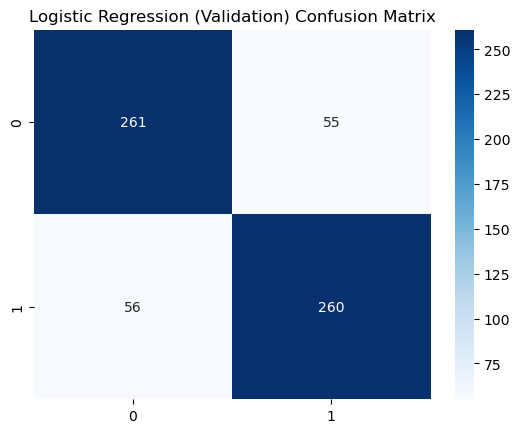

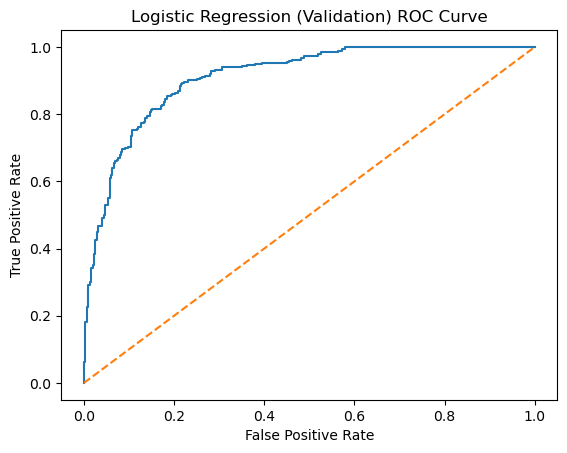


Logistic Regression (Test) Results:
Accuracy: 0.8512658227848101
Precision: 0.8557692307692307
Recall: 0.8449367088607594
F1 Score: 0.8503184713375797
AUC-ROC: 0.9277559685947765


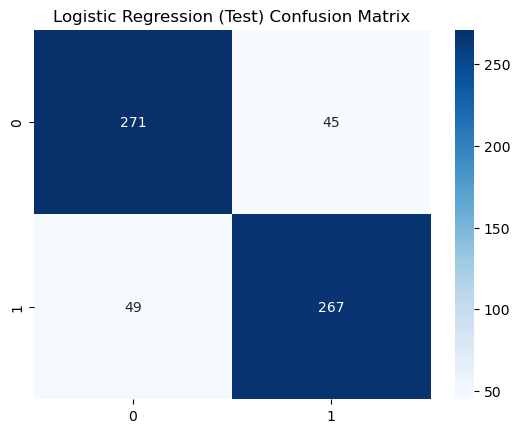

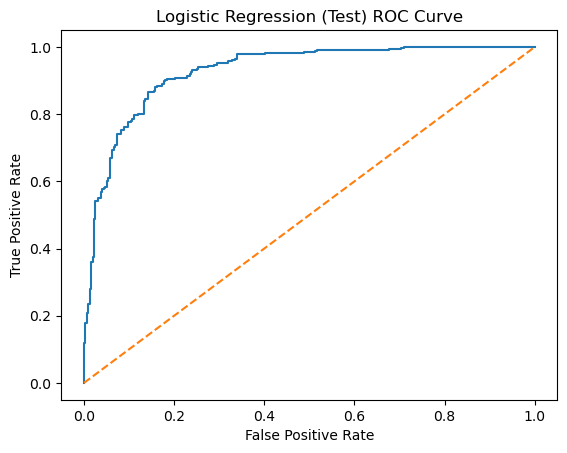


Random Forest (Validation) Results:
Accuracy: 0.9177215189873418
Precision: 0.9049079754601227
Recall: 0.9335443037974683
F1 Score: 0.9190031152647975
AUC-ROC: 0.9792100624899855


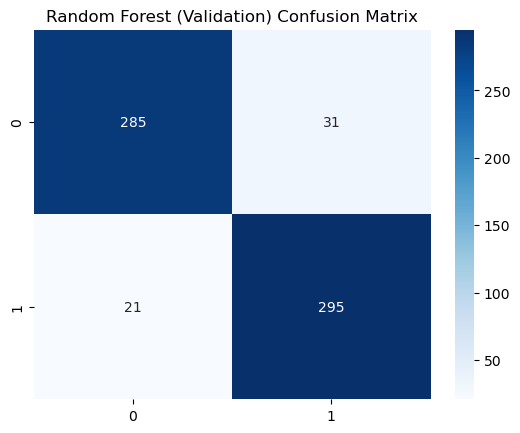

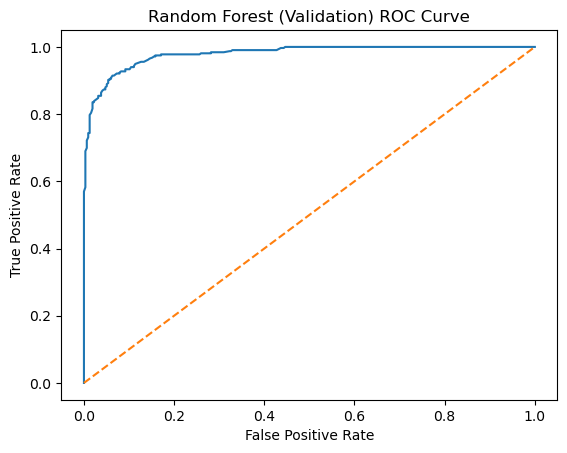


Random Forest (Test) Results:
Accuracy: 0.9145569620253164
Precision: 0.909375
Recall: 0.9208860759493671
F1 Score: 0.9150943396226415
AUC-ROC: 0.9800813170966192


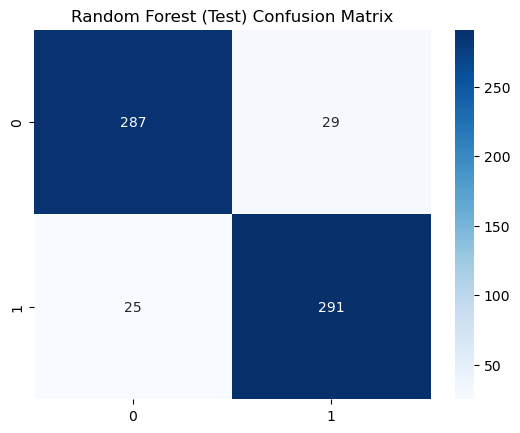

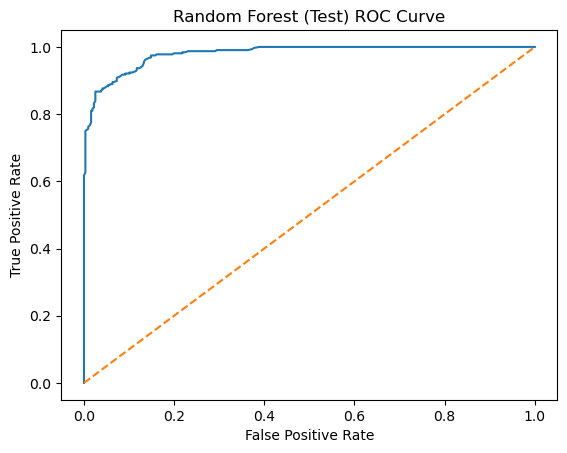

In [75]:
# Logistic Regression
evaluate(best_log_model, x_val, y_val, "Logistic Regression (Validation)")
evaluate(best_log_model, x_test, y_test, "Logistic Regression (Test)")

# Random Forest
evaluate(best_rf, x_val, y_val, "Random Forest (Validation)")
evaluate(best_rf, x_test, y_test, "Random Forest (Test)")